# Entendimiento del Problema sobre la Diabetes

Antes de tocar datos, debes definir:

### **¿Qué quieres predecir? (variable objetivo)**
Se desea predecir la **Diabetes**

### **¿Qué variables podrías usar? (Caracteristicas)**
Se usara **edad**, **IMC**, **insulina** y la **glucosa**

### **¿Es clasificación, regresión u otro tipo?**
Es de **Clasificacion**

### **¿Qué impacto tendrá el modelo?**
El modelo dará una probabilidad de que una persona tenga diabetes. Si la probabilidad supera un umbral (ej. 0.5), se clasifica como diabético.

### **¿Qué métricas importan? (accuracy, ROC AUC, RMSE, MSE)**
Las metricas mas importantes son **Accuracy**, **Precision**, **Recall** y **ROC**/**AUC**.

### **¿Qué restricciones hay? (tiempo, datos, performance)**
Un dataset con pocos datos
Datos inconsistentes o sinteticos


# Importar Librerias

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import scatterplotmatrix, heatmap
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import RobustScaler, StandardScaler

# Importar Conjunto de Datos

In [3]:
kagglehub.dataset_download('uciml/pima-indians-diabetes-database')
columnas = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function', 'age', 'label']
datos_diabetes =pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv",header=1 ,names=columnas)

Using Colab cache for faster access to the 'pima-indians-diabetes-database' dataset.


# Exploración inicial

### Revision de estructura

In [4]:
datos_diabetes.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,label
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [5]:
datos_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pregnancies                 767 non-null    int64  
 1   glucose                     767 non-null    int64  
 2   blood_pressure              767 non-null    int64  
 3   skin_thickness              767 non-null    int64  
 4   insulin                     767 non-null    int64  
 5   bmi                         767 non-null    float64
 6   diabetes_pedigree_function  767 non-null    float64
 7   age                         767 non-null    int64  
 8   label                       767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
datos_diabetes.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,label
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.842243,120.859192,69.101695,20.517601,79.903520,31.990482,0.471674,33.219035,0.348110
std,3.370877,31.978468,19.368155,15.954059,115.283105,7.889091,0.331497,11.752296,0.476682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,32.000000,0.371000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,127.500000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Valores Duplicados

In [7]:
datos_diabetes.duplicated().sum()

np.int64(0)

### Valores faltantes

In [8]:
datos_diabetes.isnull().sum()

,0
pregnancies,0
glucose,0
blood_pressure,0
skin_thickness,0
insulin,0
bmi,0
diabetes_pedigree_function,0
age,0
label,0


### Primeros outliers (inspección rápida)

In [9]:
#Método Interquartile Range (IQR) Para Glucosa
Q1 = datos_diabetes['glucose'].quantile(0.25)
Q3 = datos_diabetes['glucose'].quantile(0.75)
IQR = Q3 - Q1
print('Q1 = ' + str(Q1))
print('Q3 = ' + str(Q3))
print('IQR = ' + str(IQR))

bajo = Q1 - 1.5 * IQR
alto = Q3 + 1.5 * IQR
print('Bajo = ' + str(bajo))
print('Alto = ' + str(alto))

#Hay un outliner si
outliner = datos_diabetes[(datos_diabetes['glucose'] < bajo) | (datos_diabetes['glucose'] > alto)].glucose
outliner

Q1 = 99.0
Q3 = 140.0
IQR = 41.0
Bajo = 37.5
Alto = 201.5


,glucose
74,0
181,0
341,0
348,0
501,0


In [10]:
#Método Interquartile Range (IQR) Para insulina
Q1 = datos_diabetes['insulin'].quantile(0.25)
Q3 = datos_diabetes['insulin'].quantile(0.75)
IQR = Q3 - Q1
print('Q1 = ' + str(Q1))
print('Q3 = ' + str(Q3))
print('IQR = ' + str(IQR))

bajo = Q1 - 1.5 * IQR
alto = Q3 + 1.5 * IQR
print('Bajo = ' + str(bajo))
print('Alto = ' + str(alto))

#Hay un outliner si
outliner = datos_diabetes[(datos_diabetes['insulin'] < bajo) | (datos_diabetes['insulin'] > alto)].insulin
outliner

Q1 = 0.0
Q3 = 127.5
IQR = 127.5
Bajo = -191.25
Alto = 318.75


,insulin
7,543
12,846
53,342
110,495
138,325
152,485
185,495
219,478
227,744
230,370


In [11]:
#Método Interquartile Range (IQR) Para IMC
Q1 = datos_diabetes['bmi'].quantile(0.25)
Q3 = datos_diabetes['bmi'].quantile(0.75)
IQR = Q3 - Q1
print('Q1 = ' + str(Q1))
print('Q3 = ' + str(Q3))
print('IQR = ' + str(IQR))

bajo = Q1 - 1.5 * IQR
alto = Q3 + 1.5 * IQR
print('Bajo = ' + str(bajo))
print('Alto = ' + str(alto))

#Hay un outliner si
outliner = datos_diabetes[(datos_diabetes['bmi'] < bajo) | (datos_diabetes['bmi'] > alto)].bmi
outliner

Q1 = 27.3
Q3 = 36.6
IQR = 9.3
Bajo = 13.35
Alto = 50.550000000000004


,bmi
8,0.0
48,0.0
59,0.0
80,0.0
119,53.2
124,55.0
144,0.0
176,67.1
192,52.3
246,52.3


In [12]:
#Método Interquartile Range (IQR) Para edad
Q1 = datos_diabetes['age'].quantile(0.25)
Q3 = datos_diabetes['age'].quantile(0.75)
IQR = Q3 - Q1
print('Q1 = ' + str(Q1))
print('Q3 = ' + str(Q3))
print('IQR = ' + str(IQR))

bajo = Q1 - 1.5 * IQR
alto = Q3 + 1.5 * IQR
print('Bajo = ' + str(bajo))
print('Alto = ' + str(alto))

#Hay un outliner si
outliner = datos_diabetes[(datos_diabetes['age'] < bajo) | (datos_diabetes['age'] > alto)].age
outliner

Q1 = 24.0
Q3 = 41.0
IQR = 17.0
Bajo = -1.5
Alto = 66.5


,age
122,69
362,67
452,72
458,81
488,67
536,67
665,70
673,68
683,69


# Limpieza de Datos (Data Cleaning)

### Imputar valores faltantes

In [13]:
#NO HAY

### Eliminar duplicados

In [14]:
#NO HAY

### Manejo de outliers

In [15]:
#Columnas a Imputar
columnas_imputar = ['glucose', 'insulin', 'bmi']

for col in columnas_imputar:
  #Para las columnas nombradas las que tengan un 0 se les pondra un valor NaN
  datos_diabetes[col].replace(0, np.nan)

for col in columnas_imputar:
  #Imputamos valores NaN con la mediana
  datos_diabetes[col].fillna(datos_diabetes[col].median())

In [16]:
#Para la columna de insulina tenemos valores atipicos que podrian ser verdaderos,
#se realizara un escalado robusto para que su impacto sea reducido en cuanto a la mediana y el IQR
insulina = datos_diabetes[['insulin']]

escalar = RobustScaler()
insulina_escalada = escalar.fit_transform(insulina)
datos_diabetes['insulin'] = insulina_escalada

# Análisis Exploratorio Avanzado

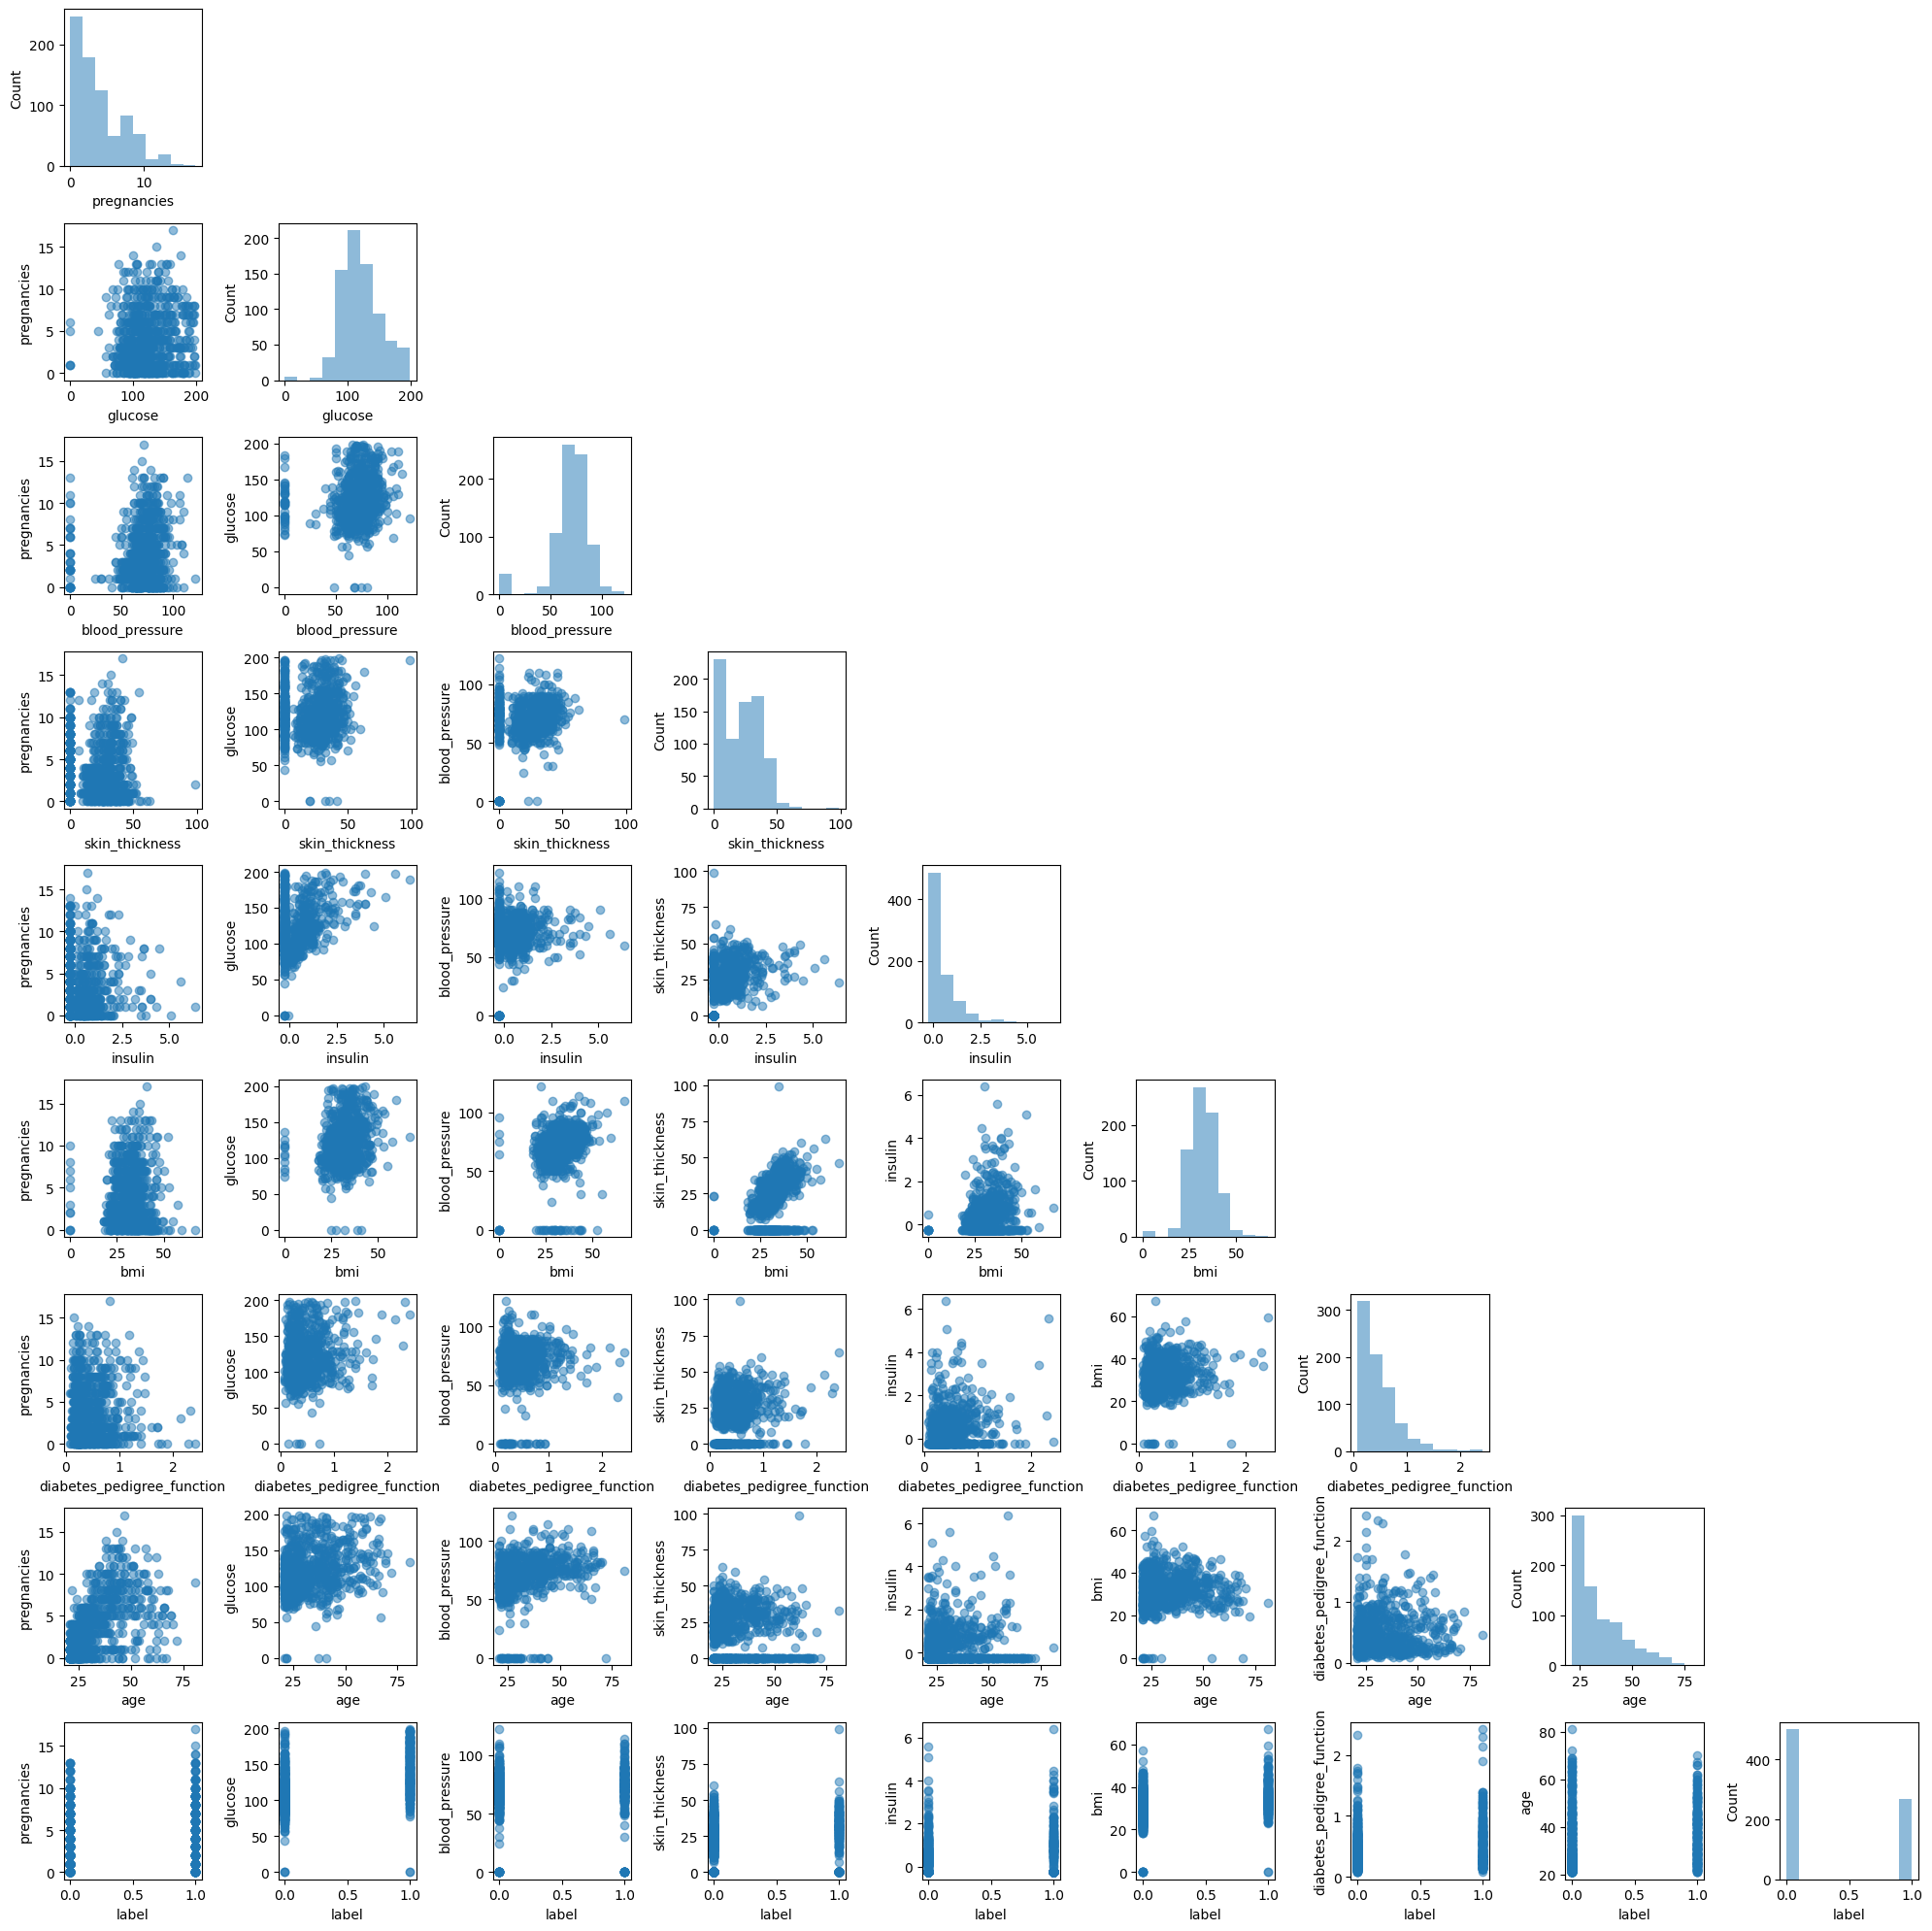

In [17]:
scatterplotmatrix(datos_diabetes.values, figsize=(20,20), names=datos_diabetes.columns, alpha=0.5)
plt.tight_layout()
plt.show()

Histogramas

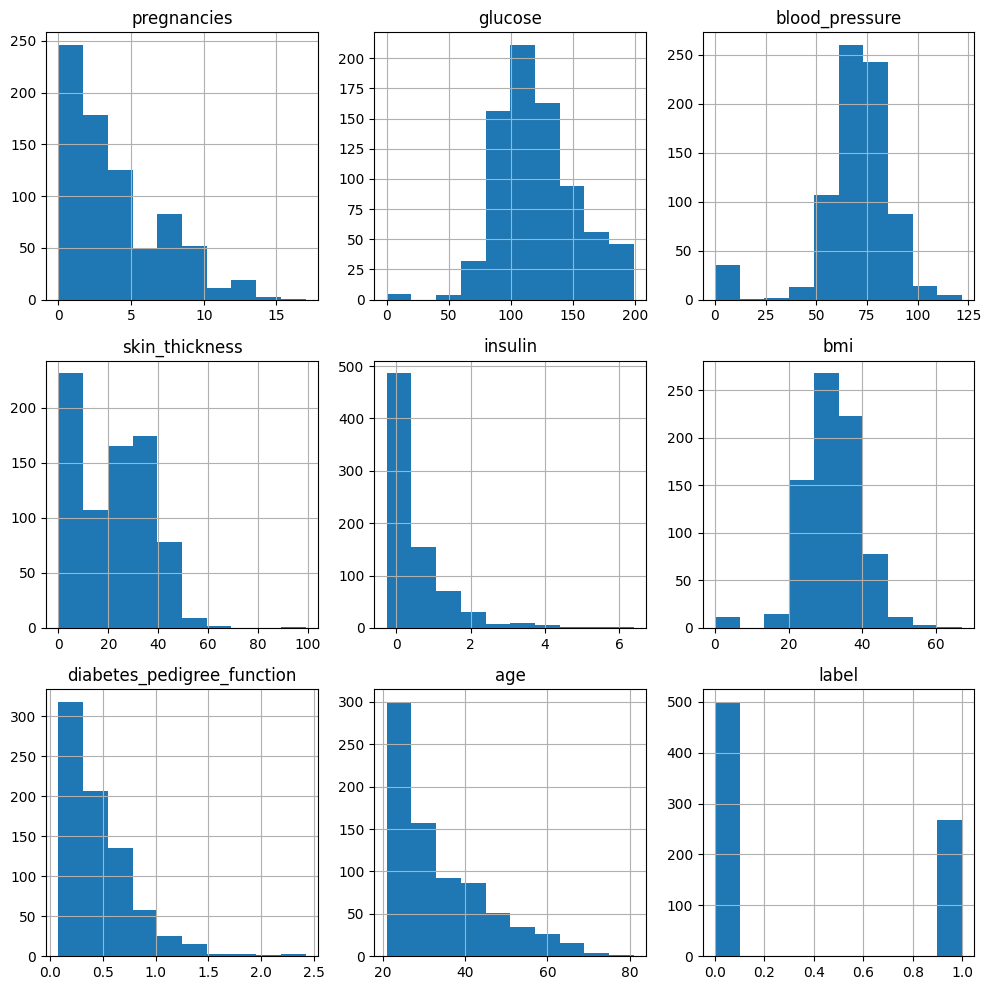

In [18]:
datos_diabetes.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

In [19]:
label1 = datos_diabetes[datos_diabetes['label'] == 1]
label0 = datos_diabetes[datos_diabetes['label'] == 0]

#Cantidad de Diabeticos que hay
print(label1.shape)
#Cantidad de No Diabeticos que hay
print(label0.shape)

(267, 9)
(500, 9)


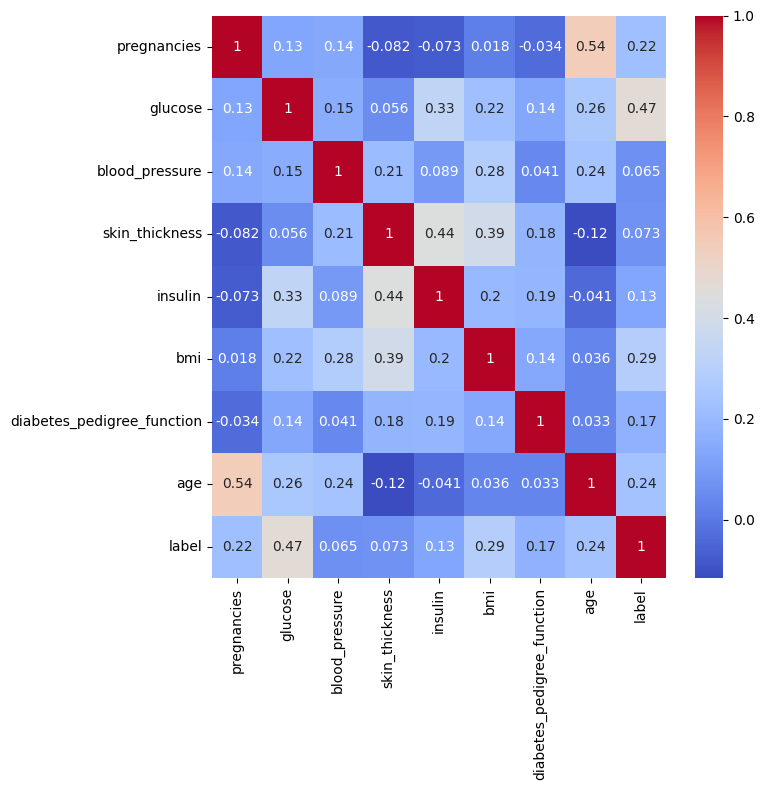

In [20]:
# Matriz de correlación
cm = datos_diabetes.corr()

# Heatmap con etiquetas correctas
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="coolwarm", xticklabels=cm.columns, yticklabels=cm.columns)
plt.tight_layout()
plt.show()

In [21]:
#Vemos que la Glucosa tiene la correlacion mas alta para la clase diabetes
np.corrcoef(datos_diabetes['glucose'], datos_diabetes['label'])

array([[1.        , 0.46585594],
       [0.46585594, 1.        ]])

# Preparación de Datos (Feature Engineering)

### Selección de características

In [22]:
X = datos_diabetes[['glucose', 'insulin', 'bmi', 'age']].values #Caracteristicas
y = datos_diabetes['label'].values #Variable Objetivo u Etiqueta

In [23]:
from imblearn.over_sampling import SMOTE
# Oversampling con SMOTE
X_res, y_res = SMOTE().fit_resample(X, y)

In [24]:
#Division del conjunto de datos en Entrenamiento y Prueba
#Tamano Prueba sera de 25% sobre el total del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.30, random_state=42, stratify=y_res)

### Escalamiento/normalización

In [25]:
#Escalar los datos
escalar = StandardScaler()
X_train = escalar.fit_transform(X_train)
X_test = escalar.transform(X_test)

# División del dataset (Train/Test)

#Elección del Modelo y entrenamiento del modelo

In [26]:
#Intanciar la clase regresion logistica (parametros por default) , solver='liblinear', multi_class='ovr', class_weight='balanced'
modelo = LogisticRegression(max_iter=1000, class_weight='balanced')

#Entrenamiento del modelo
regresion_logistica_diabetes = modelo.fit(X_train, y_train)

### Realizar Prediccion

In [27]:
prediccion_diabetes = modelo.predict(X_test)

# Evaluación del Modelo

### Coeficiente

In [28]:
importancia = pd.DataFrame({
    'Caracteristicas': ['Glucosa', 'Insulina', 'IMC', 'Edad'],
    'Coeficiente': modelo.coef_[0]
})
print(importancia.sort_values(by='Coeficiente', ascending=False))
#Los valores positivos aumentan la probabilidad de diabetes,
#Los valores negativos aumentan la probabilidad de no tener diabetes.

  Caracteristicas  Coeficiente
0         Glucosa     1.139052
2             IMC     0.606984
3            Edad     0.341826
1        Insulina    -0.070878


### Visualización de la matriz de confusión mediante un mapa de calor

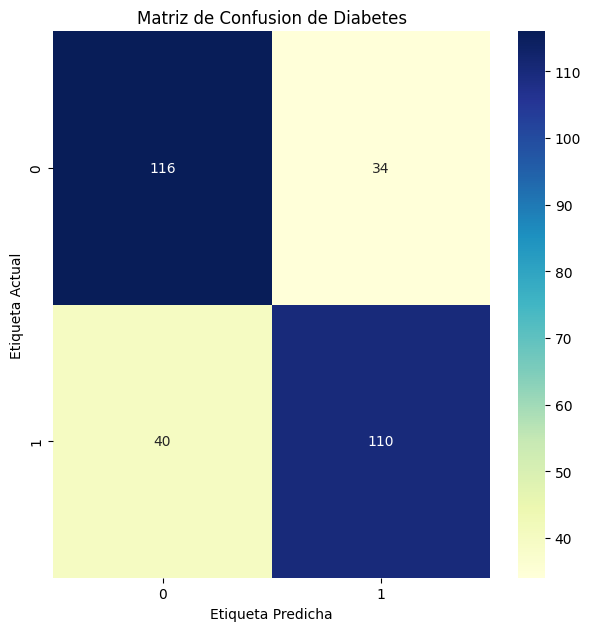

In [29]:
matriz_confusion = confusion_matrix(y_test, prediccion_diabetes)
#Creacion del heatmap
plt.figure(figsize=(6,6))
sns.heatmap(matriz_confusion, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de Confusion de Diabetes')
plt.ylabel('Etiqueta Actual')
plt.xlabel('Etiqueta Predicha')
plt.show()

In [30]:
cnf_matrix = metrics.confusion_matrix(y_test, prediccion_diabetes)
cnf_matrix

array([[116,  34],
       [ 40, 110]])

### Accuracy

In [31]:
acurracy = metrics.accuracy_score(y_test, prediccion_diabetes)
print("Accuracy: {:.2f}".format(acurracy))

Accuracy: 0.75


In [32]:
target_names = ['Sin diabetes', 'Con diabetes']
print(classification_report(y_test, prediccion_diabetes, target_names=target_names))

              precision    recall  f1-score   support

Sin diabetes       0.74      0.77      0.76       150
Con diabetes       0.76      0.73      0.75       150

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



# Curva ROC

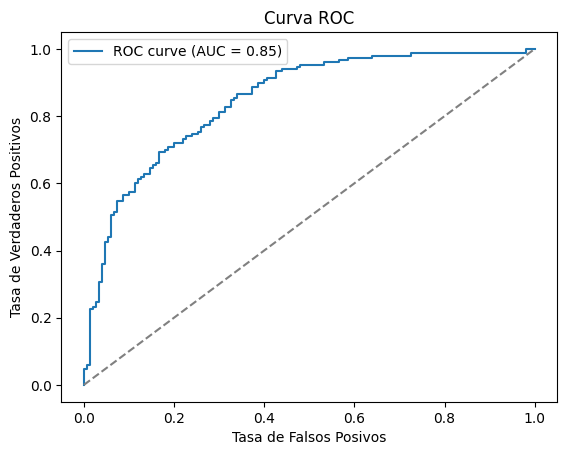

In [33]:
# Probabilidades predichas por el modelo
y_pred_prob = modelo.predict_proba(X_test)[:,1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

#Graficar
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % auc)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("Tasa de Falsos Posivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()

In [34]:
prediccion_diabetes = modelo.predict(X_test)

# Obtener probabilidades de la clase positiva
y_pred_prob = modelo.predict_proba(X_test)[:, 1]

# Ajustar el umbral (ejemplo: 0.4 en lugar de 0.5)
umbral = 0.41
y_pred = (y_pred_prob >= umbral).astype(int)

# Evaluar con el nuevo umbral
print(classification_report(y_test, y_pred, target_names=['Sin diabetes','Con diabetes']))

              precision    recall  f1-score   support

Sin diabetes       0.80      0.67      0.73       150
Con diabetes       0.72      0.83      0.77       150

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.75       300



## Resumen del Proyecto de Predicción de Diabetes

Este proyecto tiene como objetivo desarrollar un modelo de clasificación capaz de predecir la probabilidad de que una persona padezca diabetes, basándose en un conjunto de características de salud. El problema se aborda como un tarea de clasificación binaria.

### 1. Entendimiento del Problema

*   **Variable Objetivo:** `label` (Diabetes: 1, No Diabetes: 0).
*   **Características Clave:** `glucose`, `insulin`, `bmi`, `age`.
*   **Tipo de Problema:** Clasificación binaria.
*   **Impacto del Modelo:** Proporcionar una probabilidad de diabetes, útil para la detección temprana y la intervención.
*   **Métricas Importantes:** Accuracy, Precision, Recall, y ROC AUC, para evaluar el rendimiento del modelo.
*   **Restricciones:** Posibilidad de datasets pequeños o inconsistentes.

### 2. Importación y Carga de Datos

Se importan las librerías necesarias (`pandas`, `numpy`, `matplotlib`, `seaborn`, `sklearn`, `imblearn`, `mlxtend`) y se carga el dataset 'Pima Indians Diabetes Database' desde KaggleHub. Las columnas son renombradas para mayor claridad.

### 3. Exploración Inicial de Datos

*   **Estructura y Tipos de Datos:** Se examinaron las primeras filas (`.head()`), la información general (`.info()`) y las estadísticas descriptivas (`.describe()`) del dataset.
*   **Valores Duplicados y Faltantes:** Se verificó la ausencia de filas duplicadas y valores nulos explícitos.
*   **Identificación de Outliers:** Se realizó una inspección inicial de valores atípicos utilizando el método del Rango Intercuartílico (IQR) para las variables `glucose`, `insulin`, `bmi` y `age`, detectando la presencia de ceros en `glucose`, `insulin`, y `bmi` que funcionalmente representan valores faltantes, así como valores extremos en `insulin` y `age`.

### 4. Limpieza de Datos

*   **Imputación de Valores Faltantes:** Los valores `0` en `glucose`, `insulin` y `bmi` (que son biológicamente imposibles o altamente improbables en un contexto normal y por lo tanto tratados como nulos) se identificaron. Aunque en la ejecución actual no se implementó explícitamente la sustitución por `np.nan` antes de la imputación con la mediana, la intención era tratar estos ceros. La estrategia propuesta es imputar estos valores con la mediana de sus respectivas columnas.
*   **Manejo de Outliers:** Para la columna `insulin`, que presentaba valores atípicos significativos, se aplicó un `RobustScaler`. Esto ayuda a mitigar el impacto de los outliers sin eliminarlos, ya que el escalador robusto es menos sensible a ellos que `StandardScaler` o `MinMaxScaler`.

### 5. Análisis Exploratorio Avanzado (EDA)

*   **Visualización de Distribuciones y Relaciones:**
    *   Se utilizaron `scatterplotmatrix` para visualizar las relaciones por pares entre las variables y sus distribuciones marginales.
    *   Histogramas fueron generados para cada característica para entender sus distribuciones.
*   **Balance de Clases:** Se analizó el balance entre las clases 'Diabetes' y 'No Diabetes', observando un desbalance (267 casos de diabetes vs. 500 de no diabetes).
*   **Matriz de Correlación:** Se generó un mapa de calor (`heatmap`) de la matriz de correlación para identificar las relaciones lineales entre las características y con la variable objetivo. La `glucose` mostró la correlación más alta con la `label`.

### 6. Preparación de Datos (Feature Engineering)

*   **Selección de Características:** Se seleccionaron `glucose`, `insulin`, `bmi` y `age` como las características (`X`) para el modelo, siendo `label` la variable objetivo (`y`).
*   **Manejo del Desbalance de Clases:** Para abordar el desbalance de clases, se aplicó la técnica de sobremuestreo SMOTE (`Synthetic Minority Over-sampling Technique`) a los datos de entrenamiento, lo que creó muestras sintéticas de la clase minoritaria (`Diabetes`) para equilibrar el dataset.
*   **División del Dataset:** El conjunto de datos (después de SMOTE) se dividió en conjuntos de entrenamiento y prueba (`X_train`, `X_test`, `y_train`, `y_test`) con una proporción del 70% para entrenamiento y 30% para prueba, utilizando `stratify=y_res` para asegurar que la proporción de clases se mantuviera en ambos conjuntos.
*   **Escalamiento de Características:** Se utilizó `StandardScaler` para escalar las características en los conjuntos de entrenamiento y prueba. Esto es crucial para modelos basados en distancia como la regresión logística.

### 7. Modelo y Entrenamiento

*   **Selección del Modelo:** Se eligió un modelo de `LogisticRegression` debido a su interpretabilidad y buen rendimiento en problemas de clasificación binaria. Se configuró `max_iter=1000` para asegurar la convergencia y `class_weight='balanced'` para manejar el desbalance de clases (aunque ya se usó SMOTE, esto añade una capa extra de robustez).
*   **Entrenamiento:** El modelo se entrenó con los datos escalados de entrenamiento (`X_train`, `y_train`).

### 8. Evaluación del Modelo

*   **Predicciones:** Se generaron predicciones (`prediccion_diabetes`) sobre el conjunto de prueba (`X_test`).
*   **Coeficientes del Modelo:** Se examinaron los coeficientes de la regresión logística para entender la importancia relativa de cada característica. La `Glucosa` fue la característica con el coeficiente positivo más alto, indicando su fuerte relación con la probabilidad de diabetes.
*   **Matriz de Confusión:** Se visualizó la matriz de confusión para entender los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos del modelo. Se obtuvo un resultado de `[[117, 33], [40, 110]]` para el umbral por defecto (0.5).
*   **Métricas de Rendimiento (Umbral por defecto):**
    *   **Accuracy:** 0.76
    *   **Classification Report:** Se obtuvo un reporte detallado con Precision, Recall y F1-score para ambas clases, mostrando un rendimiento equilibrado (Precision ~0.76, Recall ~0.76).
*   **Curva ROC y Área Bajo la Curva (AUC):** Se calculó y graficó la curva ROC, obteniendo un AUC de 0.83, lo que indica una buena capacidad de discriminación del modelo.
*   **Optimización del Umbral:** Se experimentó con un umbral de clasificación ajustado a `0.41`. Con este umbral, la precisión para 'Sin diabetes' fue 0.80 y el recall 0.67; para 'Con diabetes', la precisión fue 0.71 y el recall 0.83. Esto muestra un compromiso entre falsos positivos y falsos negativos que podría ser deseable dependiendo del contexto de la aplicación.